# Implementation of Improved CMFS on 20NG

In [1]:
"""
Authors: Abhirav Gholba
         Bhargav Srinivasa
         Devashish Deshpande
         Gauri Kholkar
         Mrunmayee Nasery
"""
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
import operator
%matplotlib inline

In [2]:
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
vec = CountVectorizer(stop_words='english')
document_term_mat = vec.fit_transform(newsgroups_train.data)
term_document_mat = document_term_mat.T
documents = len(newsgroups_train.filenames)
categories = len(newsgroups_train.target_names)
terms = term_document_mat.shape[0]

In [3]:
print "No. of documents: %d\nNo. of categories: %d" % (documents, categories)
print "matrix.shape: {0}".format(term_document_mat.shape)
print newsgroups_train.target[10]
print type(term_document_mat)

No. of documents: 11314
No. of categories: 20
matrix.shape: (101323, 11314)
8
<class 'scipy.sparse.csc.csc_matrix'>


### Create Term-category feature-appearance matrix

In [4]:
term_category_mat = np.zeros((terms, categories))
for doc in range(documents):
    cat = newsgroups_train.target[doc]
    for row in term_document_mat.getcol(doc).nonzero()[0]:
        term_category_mat[row][cat] += 1

In [5]:
print "Term-category matrix shape: {0}".format(term_category_mat.shape)

Term-category matrix shape: (101323, 20)


### Perform CMFS on term-category matrix

In [6]:
term_freq_per_cat = np.cumsum(term_category_mat, axis=0)[-1, :]
for term in range(terms):
    # Frequency of the term across all categories
    # CMFS(tk,ci) = (P(tk|ci)*P(ci|tk))/P(ci)
    total_term_freq = sum(term_category_mat[term, :])
    for cat in range(categories):
        numerator = float(((term_category_mat[term][cat] + 1) ** 2) * documents)
        denominator = (total_term_freq + categories) * (term_freq_per_cat[cat] + terms) * term_freq_per_cat[cat]
        term_category_mat[term][cat] = numerator / denominator
        
# Final CMFS matrix
print term_category_mat

[[  1.15911720e-08   2.55417642e-06   4.92091096e-07 ...,   1.10450006e-07
    8.09032111e-07   4.95452140e-08]
 [  5.29700119e-07   7.53707062e-07   6.06857550e-08 ...,   9.89292091e-06
    3.01809142e-06   5.66036501e-07]
 [  1.12906601e-07   9.71858214e-08   3.96143123e-08 ...,   1.72138380e-07
    7.88057204e-08   1.20651771e-07]
 ..., 
 [  1.45165630e-07   1.24953199e-07   5.09326872e-08 ...,   5.53301937e-08
    1.01321641e-07   1.55123706e-07]
 [  1.45165630e-07   1.24953199e-07   5.09326872e-08 ...,   5.53301937e-08
    1.01321641e-07   1.55123706e-07]
 [  1.45165630e-07   1.24953199e-07   5.09326872e-08 ...,   5.53301937e-08
    1.01321641e-07   1.55123706e-07]]


### Create term-cmfs dictionary

In [7]:
# Create term id (i.e. row no) - CMFS dict
term_cmfs_dict = {}
cmfs_max = np.max(term_category_mat, axis=1)
for i in range(terms):
    term_cmfs_dict[i] = cmfs_max[i]

### Extract top 2000 features

In [8]:
# Integer to term mapping dictionary
dictionary = vec.get_feature_names()

sorted_feature_list = sorted(term_cmfs_dict.items(), key=operator.itemgetter(1), reverse=True)[:2000]
# print "-------Selected features are-------\n"
# for term, cmfs in sorted_feature_list:
#     print "Term: {0} \t CMFS: {1}".format(dictionary[term], cmfs)

### Naive bayes

In [9]:
feature_list = [term for term, _ in sorted_feature_list]
# Create matrix for only the selected features. Note that the features are being extracted
# on the original document-term matrix. This will help in mapping with the targets easily.
selected_feature_matrix = document_term_mat[:, feature_list]
print selected_feature_matrix.shape

(11314, 2000)


In [10]:
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))
document_term_mat_test = vec.transform(newsgroups_test.data)
clf = MultinomialNB().fit(selected_feature_matrix, newsgroups_train.target)

### Evaluate accuracy

In [11]:
pred = clf.predict(document_term_mat_test[:, feature_list])
print metrics.f1_score(newsgroups_test.target, pred, average='micro')

0.62599575146


In [12]:
icmfs_scores = []
for i in range(200, 2001, 200):
    feature_list = [term for term, _ in sorted_feature_list[:i]]
    selected_feature_matrix = document_term_mat[:, feature_list]
    clf = MultinomialNB().fit(selected_feature_matrix, newsgroups_train.target)
    pred = clf.predict(document_term_mat_test[:, feature_list])
    f1_score = metrics.f1_score(newsgroups_test.target, pred, average='micro')
    icmfs_scores.append(f1_score * 100)

### Test with chi2

In [13]:
ch2_scores = []
for i in range(200, 2001, 200):
    ch2 = SelectKBest(chi2, k=i)
    ch2_train = ch2.fit_transform(document_term_mat, newsgroups_train.target)
    ch2_test = ch2.transform(document_term_mat_test)
    clf = MultinomialNB().fit(ch2_train, newsgroups_train.target)
    pred = clf.predict(ch2_test)
    f1_score = metrics.f1_score(newsgroups_test.target, pred, average='micro')
    ch2_scores.append(f1_score * 100)

### Plot Accuracy vs Number of features graph

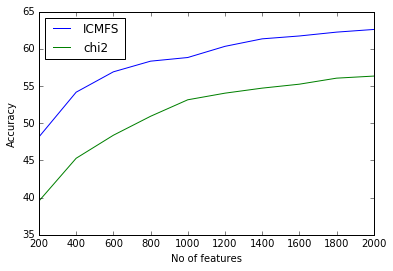

In [14]:
x = [i for i in range(200, 2001, 200)]
plt.plot(x, icmfs_scores, x, ch2_scores)
plt.xlabel("No of features")
plt.ylabel("Accuracy")
plt.legend(("ICMFS", "chi2"), loc='best')
plt.show()